# DS_SMA - Portfolio Task 2

DS-SMA <br>
Niels Siepe <br>
Mat. No.: 940583

## Story

With more than 50 million daily active users<sup>1</sup>, Reddit can be seen as a major player among social media platforms. What's special about Reddit is that the content is almost exclusively designed, posted and discussed by the users and shared on Reddit's unique community-based structures, called "subreddits".<sup>2</sup> These subreddits devide the platform into communities, which are dedicated to a single topic and provide a space for people to discuss exactly that topic. <br> Most of the time, the prupose of a subreddit is pretty straightforward. For instance, the [*r/worldnews*](https://www.reddit.com/r/worldnews/) subreddit contains news from all over the globe and the [*r/aww*](https://www.reddit.com/r/aww/) subreddit provides a platform for sharing pictures and videos of cute animals. However, there are certain anomalies among these subreddits which might not seem sensical to new users. For example, when visiting the [*r/trees*](https://www.reddit.com/r/trees/) subreddit one would possibly expect discussions about different kind of trees to be found here. Unexpectedly, this subreddit is dedicated to discussions of various topics solely related to the marihuana plant (this is likely derived from the term [*smoke trees*](https://www.urbandictionary.com/define.php?term=smoke%20trees), which is a colloquial way of describing the consumption of marihuana). Users which are interested in discussions about trees can alternatively refer to the [*r/marihuanaenthusiasts*](https://www.reddit.com/r/marijuanaenthusiasts/) subreddit, which (unlike the name suggests) deals with all topics related to actual trees. Besides discussions and sharing of images and videos, the purpose of some subreddits is quite unclear on the first glimpse. For instance, the subreddit [*r/IsTodayFridayThe13th?*](https://www.reddit.com/r/IsTodayFridayThe13th/) only contains one post per day with raises the question, if the current day is indeed Friday the 13th, which naturally is answered with *No* most of the time. If the answer is *Yes*, the post regularly blows up, receiving hundreds of comments and awards ([example from May 13th 2022](https://www.reddit.com/r/IsTodayFridayThe13th/comments/uounpa/is_today_friday_the_13th/)). <br> <br>
As these few example shows, the subreddit culture is something that is not immediately comprehensible to people unfamiliar with Reddit. Therefore, the objective of this notebook is **Reddit's subreddit structure**, with the goal of better understanding the content which is shared and discussed on the different subreddits. To achieve this, the following points will be covered: 
- Usage of Reddit API to scrape meta data of subreddits as well as reddit posts of the 200 most popular subreddits
- Computation and discussion of various subreddit related properties
- Design of custom function describing a subreddit of choice 
- Recreation of text classification task using unsupervised learning  


<sup>1</sup>: [Wall Street Journal 2020](https://www.wsj.com/articles/reddit-claims-52-million-daily-users-revealing-a-key-figure-for-social-media-platforms-11606822200) <br>
<sup>2</sup>: [Reddit - Wikipedia](https://en.wikipedia.org/wiki/Reddit#2022) 

## Prerequisites

Packages: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import random

import praw
from prawcore.exceptions import ServerError
import datetime
from itertools import product
import time
import spacy 
import re
import os

from wordcloud import WordCloud

from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics.pairwise import cosine_similarity

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, IntervalStrategy, pipeline
from datasets import load_dataset, load_metric, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

Set up API connection: 

In [30]:
with open("credentials.json") as json_file:
    credentials = json.load(json_file)

CLIENT_ID = credentials["client_id"]
SECRET_KEY = credentials["secret_key"]
USER_AGENT = credentials["user_agent"]

Comment: To reproduce the data scraping, access to the Reddit API has to be set up, which is free and only bound to the creation of a Reddit account. For further information, please refer to the [Reddit API documentation](https://www.reddit.com/dev/api/).

In [3]:
reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=SECRET_KEY, user_agent=USER_AGENT)

## Data Retrieval

First, we will get a list of the 200 most popular subreddit from which we will scrape data:

In [4]:
subreddits = []

for subreddit in reddit.subreddits.popular(limit=200):
    subreddits.append(subreddit.display_name)

Now we can scrape the subreddits and create a table containing the posts and other useful information. To get a holistic view of the posts on a subreddit, we will scrape posts from each subreddit under two categories: 
-  *hot*: when a subreddit is filtered for hot posts, recent posts which get significant attention will be displayed. These posts represent what is popular on the respective subreddit at the moment
-  *popular (all time)*: when a subreddit is filtered for the most popular posts of all time, the posts which have gotten the most traffic in total will be displayed. These posts will likely not be very recent, but offer siginificant value as their content is what was best received on the respective subreddit until now <br>

For all subreddits, we will scrape the first 100 posts for both categories, giving us a solid data foundation for the subsequent analysis.

In [5]:
scraped_data = pd.DataFrame()
meta_data = {}
limit = 100
for sub in subreddits:
    subreddit = reddit.subreddit(sub)
    categories = [("hot",subreddit.hot(limit=limit)),
                    ("most popular",subreddit.top(time_filter='all', limit=limit))]
    meta_data[subreddit.display_name] = {"language":subreddit.lang,
                            "description":subreddit.description,
                            "subscriber_count":subreddit.subscribers,
                            "active_user_count":subreddit.active_user_count
                            }           
    for cat in categories:
        try:
            for post in cat[1]:
                    data = {
                        "id": [post.id],
                        "date":[datetime.datetime.fromtimestamp(post.created_utc).date()],
                        "title": [post.title],
                        "selftext": [post.selftext],
                        "subreddit": [post.subreddit],
                        "category": [cat[0]],
                        "url": [post.url],
                        "num_comments": [post.num_comments],
                        "score": [post.score],
                        "nsfw":[post.over_18]
                    }
                    scraped_data = pd.concat([scraped_data,pd.DataFrame.from_dict(data)],ignore_index=True)
        except ServerError: 
            print("ServerError: Failed to scrape posts of subreddit: " + sub + " and category: " + cat[0])
            pass

# dropping duplicates to remove posts which show up in both categories and therefore get scraped twice 
scraped_data.drop_duplicates(inplace=True)

ServerError: Failed to scrape posts of subreddit: wallstreetbets and category: most popular
ServerError: Failed to scrape posts of subreddit: Superstonk and category: most popular


To not having to use the API for future sessions, we will save the data as a .csv file:

In [8]:
with open("reddit_meta_data.json", 'w') as outfile:
  json.dump(meta_data, outfile, indent=4)

scraped_data.to_csv("reddit_posts.csv",index=False)

No we can continue working with the saved data:

In [2]:
with open("reddit_meta_data.json", 'r') as infile:
  reddit_meta_data = json.load(infile)

df = pd.read_csv("reddit_posts.csv").fillna("")

In [3]:
all_subreddits = df["subreddit"].unique()

## Subreddit Properties

### Type of Posts

To catch a first glimpse at what kind of content is shared in Reddit, we will visualize the type of posts in total and the most dominant type per subreddit:

In [4]:
def categorize_posts(data:pd.DataFrame):
    '''
    Function counting the different type of posts in a Reddit post dataset. 
    -----------
    Parameters: 
    data : pd.DataFrame
    The data containing reddit posts. 
    -----------
    Return:
    Dictionary containing different type of posts as keys and their share of total as values. 
    '''
    posts_total = len(data)
    text_posts, video_posts, pic_posts, linked_posts, other_posts = 0, 0, 0, 0, 0
    for url in data["url"].to_list():
        if "www.reddit.com/r" in url:
            text_posts += 1
        elif ("gif" in url) or ("v.redd.it" in url):
            video_posts += 1
        elif ("png" in url) or ("jpg" in url) or ("www.reddit.com/gallery/" in url):
            pic_posts += 1
        elif ("reddit" not in url) and ("i.redd.it" not in url) and ("v.redd.it" not in url):
            linked_posts += 1
        else:
            other_posts += 1

    return {
        "image":pic_posts/posts_total,
        "link":linked_posts/posts_total,
        "text":text_posts/posts_total,
        "video/gif":video_posts/posts_total,
        "other":other_posts/posts_total
        }

In [5]:
def categorize_subreddit_posts(data:pd.DataFrame,subreddit:str):
    '''
    Function counting the different type of posts for an individual subreddit in a Reddit post dataset. 
    -----------
    Parameters: 
    data : pd.DataFrame
    The data containing reddit posts. 
    subreddit : str
    Name of the subreddit. 
    -----------
    Return:
    Dictionary containing different type of posts as keys and their share of total as values. 
    '''
    subset = data[data["subreddit"] == subreddit]
    return categorize_posts(subset)

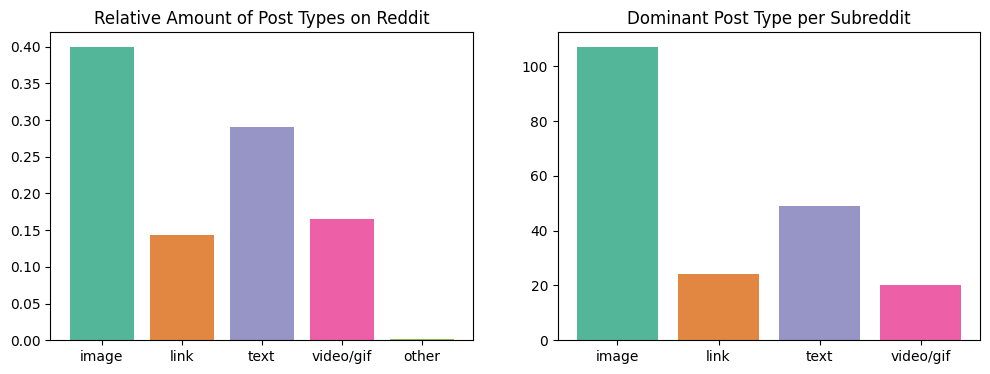

In [6]:
ratios = categorize_posts(df)

maintype_per_subreddit = []
for subreddit in all_subreddits:
    ratio = categorize_subreddit_posts(df,subreddit)
    maintype_per_subreddit.append(max(ratio,key=ratio.get))
types, counts = np.unique(np.array(maintype_per_subreddit),return_counts=True)

plot_values = [(ratios.keys(),ratios.values()),(types,counts)]
titles = ["Relative Amount of Post Types on Reddit","Dominant Post Type per Subreddit"]

fig, axes = plt.subplots(1,2,figsize=(12,4))

for values, title, ax in zip(plot_values, titles, axes.ravel()):
    ax.bar(values[0],values[1],color=sns.color_palette('Dark2'),alpha=0.75)
    ax.set_title(title)

As shown in the left plot above, despite the fact that Reddit started off as forum, only around 30% of the posts are text-based. Combined with around 55%, images and videos make up the majority of all posts being uploaded to Reddit, judging from the sample. With over 15%, external links, likely to sources like news articles or other social media platforms, such as YouTube, make up a considerable aboumt of Reddit's content as well. Other type of posts can be special threads like live news threads which are continuously updated and make up a very small fraction of all posts. <br> 
The right plot shows the main type of posts which are shared per subreddit. Due to the fact that this distribution looks very similar to the distribution on the left conveys the fact that individual subreddits tend to be dominated by one kind of post type. That means that if a subreddit mainly contains text posts, it is very likely that the other type of posts are represented very sparsly on this subreddit. The same accounts for other types of posts, such as images, videos and external links. 

### NSFW

Reddit is a platform for a mature audience, therefore allowing posts of all sort to be published on the platform by users. To make Reddit a somewhat family and work friendly media, all posts which contain sensitive content are flagged with a so-called "Not Safe For Work (NSFW)" tag. This tag applies to all posts which contain nudity, violence, graphic images or videos and other type of content which your supervisor would frown upon if he looked over your shoulder at work. To get an image of the extent of posts which are NSFW, let's have a look at the frequency of flagged posts among recently published (hot) content: 

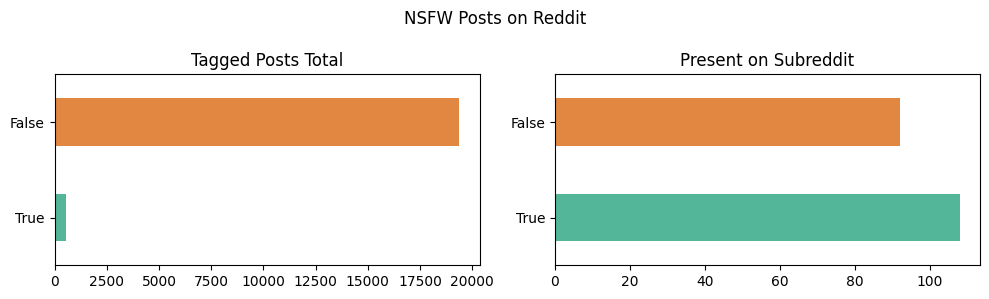

In [7]:
num_nsfw_posts = df[df["category"] == "hot"]["nsfw"].value_counts().sort_values()
nsfw_on_subreddit = df[df["category"]=="hot"].groupby("subreddit").max("nsfw")["nsfw"].value_counts()
fig, axes = plt.subplots(1,2,figsize=(10,3))
fig.suptitle("NSFW Posts on Reddit")
num_nsfw_posts.plot(kind="barh",ax=axes[0],title="Tagged Posts Total",color=sns.color_palette('Dark2'),alpha=0.75)
nsfw_on_subreddit.plot(kind="barh",ax=axes[1],title="Present on Subreddit",color=sns.color_palette('Dark2'),alpha=0.75)
plt.tight_layout()

As seen in the plot above, despite accounting for only a small fraction of all observed posts, NSFW-tagged content can be found on the majority of subreddits, showing that explicit content is not concentrated to certain subreddits but can be found at various places on the platform. 

### Content Shared on Subreddits

Now that we know what type of media is shared on Reddit, we want to take a closer look at the content which is discussed on the individual subreddits. For that, we will generate wordclouds which display the nouns and entities, which are mentioned in the titles and texts of reddit threads per subreddit. 

In [8]:
def clean_text(text:str):
        '''
        Function cleaning text. Cleaning steps specialized on Reddit scraping data. Removes special characters as well as URL's. 
        -----------
        Parameters: 
        text : str
        Text string that is to be cleaned.
        -----------
        Return:
        Cleaned text. 
        '''
        text_wo_url = re.sub(r'http\S+', '', text)
        pattern = '[_$%&/!?.:,;*\]\[()"+-]'
        return re.sub(pattern, '', text_wo_url).replace("\n","")

In [9]:
def generate_wordclouds(data:pd.DataFrame,subreddit:str,width:int=1200,height:int=800,figsize:tuple=(10,4)):
    '''
    Function generating a wordclouds for Reddit data. One wordcloud per filter category (e. g. "hot") is being displayed
    Function is taylored for English input, but can be used for German input as well. Other languages might deliver unexpected results. 
    ----------
    Parameters: 
    data : pd.DataFrame
    The data containing reddit posts. 
    subreddit : str
    Name of the subreddit.
    width : int
    The width of the generated wordcloud. Default is 1200.
    height : int
    The height of the generated wordcloud. Default is 800.
    figsize : tuple
    The size of the figure containing all wordclouds
    '''
    if subreddit not in data["subreddit"].unique():
        return "Subreddit not in data base."
    categories = data["category"].unique()
    fig, axes = plt.subplots(1,len(categories),figsize=figsize)
    fig.patch.set_facecolor("black")
    for cat, ax in zip(categories,axes):
        subset = data[(data["subreddit"] == subreddit) & (data["category"] == cat)]
        all_texts = subset["title"] + subset["selftext"]
        all_texts_cleaned_concat = all_texts.apply(lambda x: clean_text(x)).str.cat(sep=' ')
        if reddit_meta_data[subreddit]["language"] == "de":
            nlp = spacy.load("de_core_news_sm")
        else:
            nlp = spacy.load("en_core_web_md")
        doc = nlp(all_texts_cleaned_concat)
        # get nouns and entities
        nouns = [token.text for token in doc if token.pos_ == "NOUN"]
        entities = [token.text for token in doc.ents]
        words = nouns + entities
        # initialize words for wordcloud
        words_as_string = ""
        for word in words:
                words_as_string = words_as_string + " " + word

        wordcloud = WordCloud(height=height,width=width).generate(words_as_string)

        # display the generated wordcloud:
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title(cat +" posts",fontdict={"color": "grey", "size": 18, "family": "monospace", "style": "italic"})
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    plt.subplots_adjust(left=0.2, right=0.8)
    plt.tight_layout()

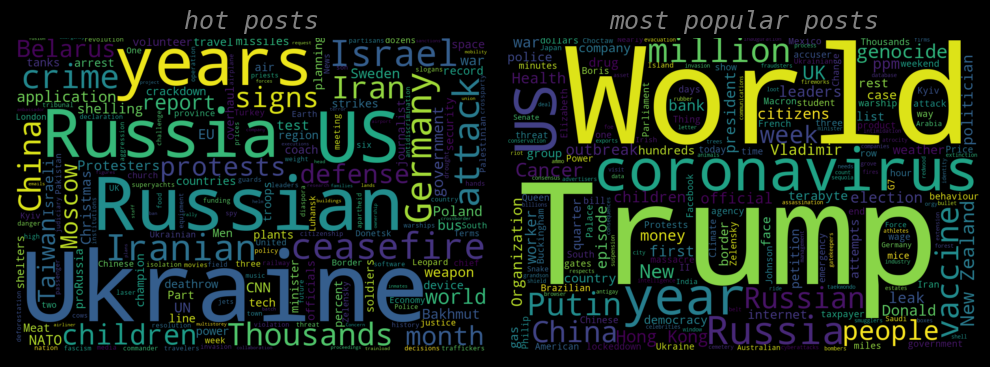

In [10]:
generate_wordclouds(df,"worldnews")

Taking the *r/worldnews* subreddit as an example, the above wordclouds show that recently, the war in Ukrain is the main topic of discussion on this subreddit. Other topics include Israel, Iran and the US. Looking at what is the content of the threads which received the most attention all time, Donald Trump and various topics connected to the corona pandemic are among the most discussed entities. 

### Semantic Similarity between Subreddits

To draw connections between different subreddits, we will look at semantic similarities, with the goal of generating similar subreddits for each. The approach we will take is related to the design of a content-based recommender system. First, we will train word embeddings on the whole text corpus of our data base using a Word2Vec model, which we will then use to generate word vectors for each subreddit in our data base. We can then leverage these vectors to compute similarities between them, thus generating similar subreddits per individual subreddit.

In [11]:
def get_corpus(data:pd.DataFrame):
    '''
    Function generating a text corpus from Reddit data. 
    This function is taylored for English input. Other languages might deliver unexpected results.
    ----------
    Parameters: 
    data : pd.DataFrame
    The data containing reddit posts. 
    -----------
    Return:
    Text corpus as list of lists. 
    '''
    corpus = []
    for text in (data["title"] + data["selftext"]):
        split_entry = remove_stopwords(clean_text(text),stopwords.words('english')).split()
        corpus.append(split_entry)
    return corpus

Train Word2Vec embeddings:

In [12]:
corpus = get_corpus(df)
word2vec = Word2Vec(vector_size=80,
                    window=6,
                    min_count=6,
                    seed=1,
                    sg=0)
word2vec.build_vocab(corpus_iterable=corpus)
word2vec.train(corpus_iterable=corpus, total_examples=len(corpus), epochs=10) 
word2vec.wv.vectors.shape

(21489, 80)

Create corpus for each subreddit for later similarity computing: 

In [13]:
subreddit_dict = {i:subreddit for i,subreddit in enumerate(all_subreddits)}
subreddit_dict_inv = {v:k for k,v in subreddit_dict.items()}

In [14]:
subreddit_texts = []
data = df.copy() 
for subreddit in all_subreddits:
    subset = data[data["subreddit"] == subreddit]
    texts = get_corpus(subset)
    subreddit_texts.append([word for sublist in texts for word in sublist])

Create vector for each subreddit corpus: 

In [15]:
# get word vectors 
all_vectors = np.zeros((df["subreddit"].nunique(),80))
# go through every corpus entry
for i,text in enumerate(subreddit_texts):
    subreddit_vector = np.zeros((len(text),80))
    # take every word vector for each word in corpus entry
    # if none found, pass
    for j,word in enumerate(text):
        try:
            subreddit_vector[j] = word2vec.wv[word]
        except KeyError:
            pass
    # average all vectors to one and add the created "average text vector" to all vectors 
    all_vectors[i] = np.mean(subreddit_vector,axis=0)

# check if result is of desired shape
all_vectors.shape

(200, 80)

Write function for similarity computation:

In [16]:
def get_similar_subreddits(subreddit:str,n:int=5):
    '''
    Function recommending subreddits based on their semantic similarities. 
    ----------
    Parameters: 
    subreddit : str
    Name of the subreddit.
    ----------
    Return: 
    Top n most similar subreddits.
    '''
    idx = subreddit_dict_inv[subreddit]
    # use dot product as similarity function as it produces the best results 
    sims = cosine_similarity(all_vectors,all_vectors)
    sim_scores = list(enumerate(sims[idx]))
    # sort similarities and take top 5 entries
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
    return [subreddit_dict[i[0]] for i in sim_scores]

In [17]:
get_similar_subreddits("funny",5)

['KidsAreFuckingStupid', 'MadeMeSmile', 'aww', 'cats', 'Wellthatsucks']

As shown above, the most similar subreddits to *r/funny* regarding semantics are subreddits which contain more or less light-hearted content, like images of cats and other cute animals.

### Popularity Rank

Lastly, we want to calculate a popularity measure for all examined subreddits. This will take the following popularity indicators into account and calculate one score for each subreddit: 
- global indicators: 
    - subscriber count 
    - active user counter 
- indicators regarding posts: 
    - median score of posts (score = difference between upvotes and downvotes)
    - median amount of comments per post

In [18]:
scoreboard = pd.DataFrame(columns=["subreddit","subscriber","active_user","median_comments","median_score"])
for i, subreddit in enumerate(all_subreddits):
    subscriber = reddit_meta_data[subreddit]["subscriber_count"]
    active_user = reddit_meta_data[subreddit]["active_user_count"]
    median_comments = df[df["subreddit"] == subreddit]["num_comments"].median()
    median_score = df[df["subreddit"] == subreddit]["num_comments"].median()
    scoreboard.loc[i] = [subreddit,subscriber,active_user,median_comments,median_score]

# scaling all measures to equal their weight on the final score
for column in ["subscriber","active_user","median_comments","median_score"]:
    scaler = MinMaxScaler()
    scoreboard[column] = scaler.fit_transform(scoreboard[[column]].values)

scoreboard = scoreboard.assign(popularity_score=lambda x: x["subscriber"] + x["active_user"] + x["median_comments"] + x["median_score"]).sort_values(by="popularity_score",ascending=False).reset_index(drop=True)

# create a dict assigning each subreddit to their index of the sorted scoreboard (which is their final ranking)
popularity_rank_dict = {subreddit:scoreboard[scoreboard["subreddit"] == subreddit].index[0]+1 for subreddit in all_subreddits}

scoreboard.head(5)

,subreddit,subscriber,active_user,median_comments,median_score,popularity_score
0,AskReddit,0.845329,0.958297,1.000000,1.000000,3.803626
1,worldnews,0.660121,0.579057,0.741490,0.741490,2.722158
2,news,0.551963,0.214037,0.844412,0.844412,2.454825
3,movies,0.648380,0.444819,0.585260,0.585260,2.263719
4,funny,1.000000,0.682191,0.285645,0.285645,2.253482


Representing the subreddits in a DataFrame and sorting it by the calculated popularity score allows us to observe the subreddits in order of descending popularity. Above the five most popular subreddits can be seen. 

### Combining All Measures

Now, that we computed a lot of individual properties for subreddits, we can combine the findings in one function, which we can then call to get a comprehensive discription of a subreddit of choice. This way, we can easily get information about a subreddit which sparks our interest.

In [19]:
def describe_subreddit(data:pd.DataFrame, meta_data:dict, subreddit:str):
    '''
    Function printing various properties for a passed subreddit. 
    ----------
    Parameters: 
    data : pd.DataFrame
    The data containing reddit posts.
    meta_data : dict
    Dict containing meta data for subreddits. 
    subreddit : str 
    Name of the subreddit.
    '''
    if subreddit not in data["subreddit"].unique():
        return "Subreddit not in data base."
    else:
        print("""The subreddit \033[1mr/{}\033[0m has {} subscribers, {} active users and is on popularity rank {} of all subreddits in the database.
        
The composition of media shared on this subreddit is as follows:

{}

Of all {} observed posts on this subreddit, {} are tagged as NSFW.

Similar subreddits to \033[1mr/{}\033[0m are: {}
        
These wordclouds resemble discussed topics on \033[1mr/{}\033[0m:
                """.format(subreddit,
                reddit_meta_data[subreddit]["subscriber_count"],
                reddit_meta_data[subreddit]["active_user_count"],
                popularity_rank_dict[subreddit],
                categorize_subreddit_posts(data,subreddit),
                len(data[data["subreddit"] == subreddit]),
                len(data[(data["subreddit"] == subreddit) & data["nsfw"] == True]),
                subreddit, 
                ', '.join(["r/"+subreddit for subreddit in get_similar_subreddits(subreddit,5)]),
                #get_similar_subreddits(subreddit,5),
                subreddit))
        generate_wordclouds(data,subreddit)

The subreddit r/news has 25663320 subscribers, 15656 active users and is on popularity rank 3 of all subreddits in the database.
        
The composition of media shared on this subreddit is as follows:

{'image': 0.0, 'link': 0.99, 'text': 0.0, 'video/gif': 0.0, 'other': 0.01}

Of all 200 observed posts on this subreddit, 0 are tagged as NSFW.

Similar subreddits to r/news are: r/nottheonion, r/worldnews, r/UkraineWarVideoReport, r/ukraine, r/PublicFreakout
        
These wordclouds resemble discussed topics on r/news:
                


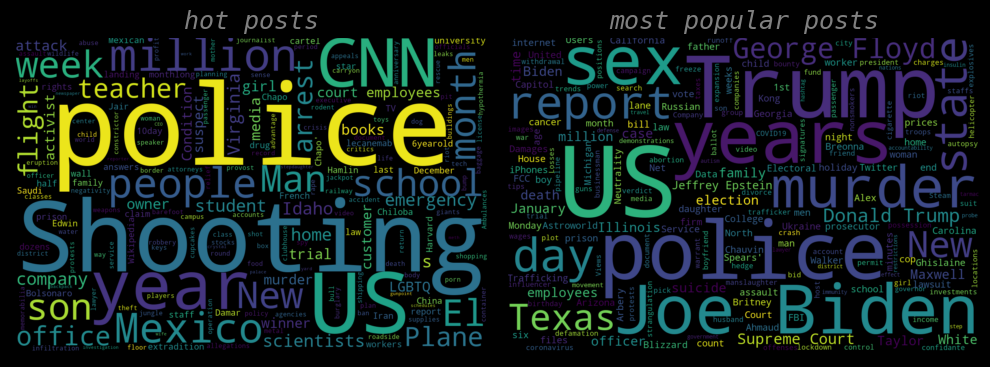

In [20]:
describe_subreddit(df,reddit_meta_data,"news")

Using this function while using Reddit and exploring subreddits allows us to observe all properties which we computed beforehand on one view while adding meta data for context. Additionally, the function can be reused to for example check out a subreddit which is related to the one we are currently looking at. <br> <br>
If the user doesn't know many subreddits, the following function can be used to explore the subreddits contained in the database.

In [21]:
def discover_subreddit(data:pd.DataFrame, meta_data:dict):
    '''
    Function printing various properties for a random subreddit. 
    ----------
    Parameters: 
    data : pd.DataFrame
    The data containing reddit posts.
    meta_data : dict
    Dict containing meta data for subreddits. 
    '''
    subreddits = data["subreddit"].unique()
    index = random.randint(0,len(subreddits))
    describe_subreddit(data,meta_data,subreddits[index])

The subreddit r/WhitePeopleTwitter has 2769888 subscribers, 28493 active users and is on popularity rank 26 of all subreddits in the database.
        
The composition of media shared on this subreddit is as follows:

{'image': 0.995, 'link': 0.0, 'text': 0.005, 'video/gif': 0.0, 'other': 0.0}

Of all 200 observed posts on this subreddit, 0 are tagged as NSFW.

Similar subreddits to r/WhitePeopleTwitter are: r/MurderedByWords, r/facepalm, r/clevercomebacks, r/BlackPeopleTwitter, r/conspiracy
        
These wordclouds resemble discussed topics on r/WhitePeopleTwitter:
                


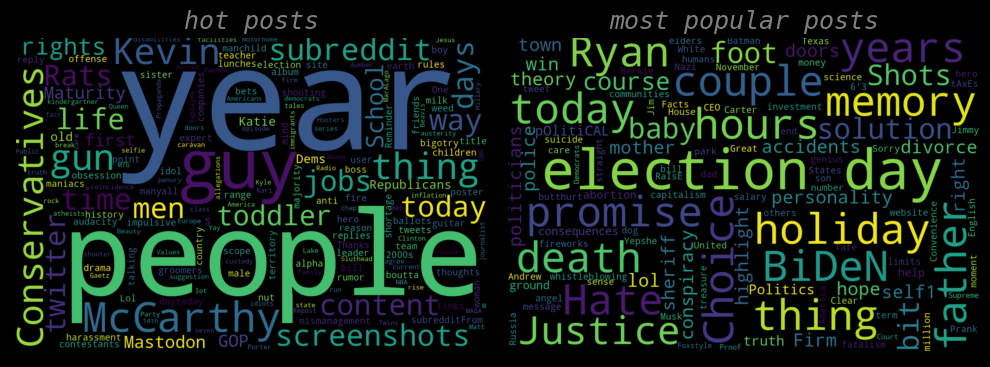

In [46]:
discover_subreddit(df,reddit_meta_data)

## Text Classification of Reddit Posts

Since there are so many subreddits the choose from, it can be quite challenging to find the subreddit best fit for the content you want to share or question you want to ask. We want to take this problem as motivation for the following task and design a text classification model which can predict the subreddit a post is shared on. If we are able to design an accurate model, which is able to predict the subreddit of existing posts on Reddit, we can utilize this model to give us the appropriate subreddit for a custom written text. Therefore, in the future one would only have to write their content and then use the classification model to predict which subreddit would be a good fit for it. <br> <br>
Related works on this topic, as for example the experiments of Gutman/Nam<sup>3</sup> tackle this problem by training word embeddings and then running supervised classfication algorithms on these embeddings to classify the instances. Their best performing model, a support vector machine, achieves an accuracy of 77.3%. <br>
In this notebook, we want to find out whether an unsupervised transformer model can outperform the model performance of Gutman/Nam. In details, we will use the scraped data and fine-tune the pretrained base model of DistilBERT on this data, subsequently using it for the classification. To be able to compare the results, we will only look at the following five subreddits: *r/movies*, *r/news*, *r/nfl*, *r/pcmasterrace* and *r/relationship_advice*<sup>4</sup>. <br> <br>
<sup>4</sup>: Gutman/Nam are using the *r/relationships* subreddit instead of *r/relationship_advice*. Since *r/relationships* is not part of our data base, *r/relationship_advice* serves as best possible substitute

Create subset of data for classification task: 

In [23]:
df_subset = df[df["subreddit"].isin(["movies","pcmasterrace","news","nfl","relationship_advice"])]
# taking both title and post content as basis for classification 
df_text = df_subset["title"] + df_subset["selftext"]

# class_df = df_subset[["Sentiment","subreddit"]].rename({"subreddit":"label"},axis=1)
class_df = pd.concat([df_text,df_subset["subreddit"]],axis=1).rename({0:"text","subreddit":"label"},axis=1)
class_df["text"] = class_df["text"].apply(lambda x : clean_text(x))

# creating labels and according according to subset data, important to sort the list so the labels don't get mixed up later
labels = sorted(class_df["label"].unique())
label_id = {i:l for i,l in enumerate(labels)}

Train-val-test split: 

In [24]:
train_set, test_val_set = train_test_split(class_df, train_size=0.8, random_state=1)
test_set, validation_set = train_test_split(test_val_set, train_size=0.5, random_state=1)

train = Dataset.from_pandas(train_set, split="train", preserve_index=False)
validation = Dataset.from_pandas(validation_set, split="validation", preserve_index=False)
test = Dataset.from_pandas(test_set, split="test", preserve_index=False)

data = DatasetDict({"train": train,"validation":validation, "test": test})
data = data.class_encode_column("label")
data

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
})

Define the task and which pre-trained model to use:

In [25]:
task = "subreddit_classification"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16
metric = load_metric("accuracy")
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

C:\Users\niels.siepe\AppData\Local\Temp\ipykernel_18048\2522213349.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Preprocess data: 

In [26]:
def preprocess_function(dataset:DatasetDict):
    '''
    Function preprocessing data for text classification. 
    ----------
    Parameters: 
    data : DatasetDict
    Data which is to be preprocessed. 
    ----------
    Return: 
    Preprocessed data. 
    '''
    return tokenizer(dataset["text"], truncation=True)

In [27]:
tokenized_dataset = data.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Load model: 

In [28]:
num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels, 
    ignore_mismatched_sizes=True, 
    id2label=label_id)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Define arguments for training:

In [31]:
HF_TOKEN = credentials["huggingface_token"]

Comment: To reproduce the fine-tuning of the DistilBERT model a token has to be generated. This is completely free and only bound to signing up to hugging face. For further information please refer to [Hugging Face - User access tokens](https://huggingface.co/docs/hub/security-tokens).

In [32]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    optim="adamw_torch",
    evaluation_strategy = IntervalStrategy.STEPS,
    eval_steps = 30,
    logging_steps = 30,
    save_steps = 90,
    save_total_limit = 5, 
    save_strategy = "steps",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to="all",
    hub_token=HF_TOKEN
)

In [33]:
def compute_metrics(eval_pred):
    '''
    Function computing a metric during evaluation. 
    ----------
    Parameters: 
    eval_pred 
    Evaluation predictions.  
    ----------
    Return: 
    Computed metric. 
    '''
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Initialize trainer and start fine-tuning:

In [34]:
tokenized_dataset = tokenized_dataset.remove_columns("text")
trainer = Trainer(
    model = model,
    args = args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
)

c:\Users\niels.siepe\Desktop\Priv\VS Code\DS_SMA\distilbert-base-uncased-finetuned-subreddit_classification is already a clone of https://huggingface.co/nillo36/distilbert-base-uncased-finetuned-subreddit_classification. Make sure you pull the latest changes with `repo.git_pull()`.


In [35]:
trainer.train()

***** Running training *****
  Num examples = 800
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 250


  0%|          | 0/250 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


{'loss': 1.4142, 'learning_rate': 1.76e-05, 'epoch': 0.6}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.2652652263641357, 'eval_accuracy': 0.45, 'eval_runtime': 22.8529, 'eval_samples_per_second': 4.376, 'eval_steps_per_second': 0.306, 'epoch': 0.6}


***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


{'loss': 0.9856, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.2}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.7754375338554382, 'eval_accuracy': 0.87, 'eval_runtime': 23.2792, 'eval_samples_per_second': 4.296, 'eval_steps_per_second': 0.301, 'epoch': 1.2}


***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


{'loss': 0.5056, 'learning_rate': 1.2800000000000001e-05, 'epoch': 1.8}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-finetuned-subreddit_classification\checkpoint-90
Configuration saved in distilbert-base-uncased-finetuned-subreddit_classification\checkpoint-90\config.json


{'eval_loss': 0.4413411021232605, 'eval_accuracy': 0.9, 'eval_runtime': 22.8193, 'eval_samples_per_second': 4.382, 'eval_steps_per_second': 0.307, 'epoch': 1.8}


Model weights saved in distilbert-base-uncased-finetuned-subreddit_classification\checkpoint-90\pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-subreddit_classification\checkpoint-90\tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-subreddit_classification\checkpoint-90\special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-subreddit_classification\tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-subreddit_classification\special_tokens_map.json
Several commits (2) will be pushed upstream.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


{'loss': 0.2248, 'learning_rate': 1.04e-05, 'epoch': 2.4}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2983710765838623, 'eval_accuracy': 0.92, 'eval_runtime': 23.1304, 'eval_samples_per_second': 4.323, 'eval_steps_per_second': 0.303, 'epoch': 2.4}


***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


{'loss': 0.1352, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.3265467584133148, 'eval_accuracy': 0.89, 'eval_runtime': 20.7171, 'eval_samples_per_second': 4.827, 'eval_steps_per_second': 0.338, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


{'loss': 0.0856, 'learning_rate': 5.600000000000001e-06, 'epoch': 3.6}


  0%|          | 0/7 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-finetuned-subreddit_classification\checkpoint-180
Configuration saved in distilbert-base-uncased-finetuned-subreddit_classification\checkpoint-180\config.json


{'eval_loss': 0.2957996129989624, 'eval_accuracy': 0.91, 'eval_runtime': 26.1, 'eval_samples_per_second': 3.831, 'eval_steps_per_second': 0.268, 'epoch': 3.6}


Model weights saved in distilbert-base-uncased-finetuned-subreddit_classification\checkpoint-180\pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-subreddit_classification\checkpoint-180\tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-subreddit_classification\checkpoint-180\special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-subreddit_classification\tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-subreddit_classification\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


{'loss': 0.0715, 'learning_rate': 3.2000000000000003e-06, 'epoch': 4.2}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2611418068408966, 'eval_accuracy': 0.92, 'eval_runtime': 20.0551, 'eval_samples_per_second': 4.986, 'eval_steps_per_second': 0.349, 'epoch': 4.2}


***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


{'loss': 0.0615, 'learning_rate': 8.000000000000001e-07, 'epoch': 4.8}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2737983763217926, 'eval_accuracy': 0.93, 'eval_runtime': 22.4153, 'eval_samples_per_second': 4.461, 'eval_steps_per_second': 0.312, 'epoch': 4.8}




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-uncased-finetuned-subreddit_classification\checkpoint-180 (score: 0.91).


{'train_runtime': 2344.3711, 'train_samples_per_second': 1.706, 'train_steps_per_second': 0.107, 'train_loss': 0.4216693789958954, 'epoch': 5.0}


TrainOutput(global_step=250, training_loss=0.4216693789958954, metrics={'train_runtime': 2344.3711, 'train_samples_per_second': 1.706, 'train_steps_per_second': 0.107, 'train_loss': 0.4216693789958954, 'epoch': 5.0})

Evaluate results: 

In [36]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 100
  Batch size = 16


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2957996129989624,
 'eval_accuracy': 0.91,
 'eval_runtime': 21.2085,
 'eval_samples_per_second': 4.715,
 'eval_steps_per_second': 0.33,
 'epoch': 5.0}

As shown in the evaluation above, the fine-tuned DistilBERT model significantly outperforms the supervised models from the paper and scores an accuracy of above 90% on the evaluation data. We will now go ahead and demonstrate the model's performance on the test data:

In [37]:
output, preds, metrics = trainer.predict(tokenized_dataset["test"])
test_set["preds"] = [label_id[pred] for pred in preds]
test_set.head(5)

***** Running Prediction *****
  Num examples = 100
  Batch size = 16


  0%|          | 0/7 [00:00<?, ?it/s]

,text,label,preds
2865,Was the Torture Scene in Reservoir Dogs really...,movies,movies
3672,Is this a good fan configuration All 140mm,pcmasterrace,pcmasterrace
2989,Ryan Reynolds’ 'Free Guy' Receives July 3 2020...,movies,movies
2808,Real Genius 1985 starring Val Kilmer William A...,movies,movies
3652,Painted the panels on my Corsair 5000d white w...,pcmasterrace,pcmasterrace


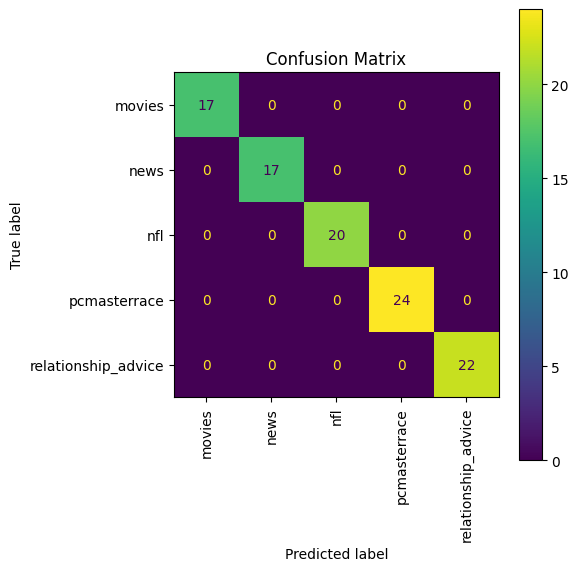

In [38]:
cm = confusion_matrix(test_set["label"].to_list(),test_set["preds"].to_list(),labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.title("Confusion Matrix",fontsize=12)
plt.tight_layout()

The confusion matrix shows that our model actually manages to classify all 100 test instances correctly. We can therefore confidently say that the fine-tuned model is well fit for the given task. Judging from this performance, there is definitely potential to increase the number of different subreddits, which are taken into account for the classification, potentially leading to the possibility of using this model as aid to find the right subreddit for posting individual content as mentioned in the motivation. 

Deploy model for future use: 

In [39]:
data.push_to_hub(repo_id="RedditProject",token=HF_TOKEN)
trainer.push_to_hub()

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split validation to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split test to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-finetuned-subreddit_classification
Configuration saved in distilbert-base-uncased-finetuned-subreddit_classification\config.json
Model weights saved in distilbert-base-uncased-finetuned-subreddit_classification\pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-subreddit_classification\tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-subreddit_classification\special_tokens_map.json


Upload file runs/Jan09_17-24-49_NB-20000932/events.out.tfevents.1673281495.NB-20000932.18048.0: 100%|#########…

Upload file runs/Jan09_17-24-49_NB-20000932/events.out.tfevents.1673283930.NB-20000932.18048.2: 100%|#########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/nillo36/distilbert-base-uncased-finetuned-subreddit_classification
   e5d6cac..6bade6d  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.91}]}
To https://huggingface.co/nillo36/distilbert-base-uncased-finetuned-subreddit_classification
   6bade6d..cd218d1  main -> main



'https://huggingface.co/nillo36/distilbert-base-uncased-finetuned-subreddit_classification/commit/6bade6d1b499177f98624c56478373af13ac63c1'

In [40]:
pipe = pipeline(task="text-classification", model="nillo36/distilbert-base-uncased-finetuned-subreddit_classification")

loading configuration file https://huggingface.co/nillo36/distilbert-base-uncased-finetuned-subreddit_classification/resolve/main/config.json from cache at C:\Users\niels.siepe/.cache\huggingface\transformers\7cc558688d6a52c776d0122b47498d52e48c3c49af8cf0b4907b192b7770e714.9af7e34d2af0e065daf560d49dd1bed7de5a995319faedac7076955abf0fd242
Model config DistilBertConfig {
  "_name_or_path": "nillo36/distilbert-base-uncased-finetuned-subreddit_classification",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "movies",
    "1": "news",
    "2": "nfl",
    "3": "pcmasterrace",
    "4": "relationship_advice"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,


storing https://huggingface.co/nillo36/distilbert-base-uncased-finetuned-subreddit_classification/resolve/main/pytorch_model.bin in cache at C:\Users\niels.siepe/.cache\huggingface\transformers\50f90759a3ccc9261e4d80606189f38137cc241ec8d1f213894a1ca0d0ac74f4.8f541d91ed81c2d1d3fa1985b19e341d7325fc0b26910e0cf406b0bb71d79302
creating metadata file for C:\Users\niels.siepe/.cache\huggingface\transformers\50f90759a3ccc9261e4d80606189f38137cc241ec8d1f213894a1ca0d0ac74f4.8f541d91ed81c2d1d3fa1985b19e341d7325fc0b26910e0cf406b0bb71d79302
loading weights file https://huggingface.co/nillo36/distilbert-base-uncased-finetuned-subreddit_classification/resolve/main/pytorch_model.bin from cache at C:\Users\niels.siepe/.cache\huggingface\transformers\50f90759a3ccc9261e4d80606189f38137cc241ec8d1f213894a1ca0d0ac74f4.8f541d91ed81c2d1d3fa1985b19e341d7325fc0b26910e0cf406b0bb71d79302
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertFor

Now, the model can be used to predict custom texts and sort them to the subreddits which were part of the experiment: 

In [41]:
pipe("""So here’s my situation.

My girlfriend (26 F) and I (25 M) have been together for 8 years. We moved in together a year ago.

I love her and we often have a ton of chemistry. Many things are great in our relationship. 

However, her mom really doesn't like me since I accidentily drowned her cat in the bathtub a year ago.

We will be at her parents place for the holidays. What can I do to gain her mother's trust again?""")

[{'label': 'relationship_advice', 'score': 0.8560050129890442}]

In [42]:
pipe("I just bought a new PC but my RAM is insufficient for my machine learning tasks which I do for my study program. Any advice on how to upgrade my RAM?")

[{'label': 'pcmasterrace', 'score': 0.9545684456825256}]

## Conclusion

In summary, the analysis conducted in this notebook shed light on what kind of content is shared on the various subreddits, in which the social media platform Reddit is devided. With the function *describe_subreddit()*, it is possible to get the following information regarding a subreddit of choice: 
- amount of subscribers and active users
- how popular the subreddit is (measured through combination of four different indicators)
- what kind of media is shared and whether the content is tagged as NSFW
- which other subreddits are related based on semantic similarites
- what the content of posts on this subreddit is, represented by wordclouds <br>

Getting all these properties on one view enables the user to get a thorough overview over a subreddit of choice. <br> <br>
Furthermore, it was able to fine-tune a pre-trained classification model on the gathered data which is able to most accurately classify posts of five different subreddits by their text. Due to the high accuracy the model achieved, further potential to expand this model on a wider range of subreddits is evident. <br> <br>
Looking at possible future research, there is still potential to expand the conducted experiments besides the mentioned enlargement of the text classifiation model. For instance, the API could be used to a greater extent, gathering more posts from additional subreddits leading to a more holistic view of Reddit's structure and content.<br> Additionally, besides the analysis of all text-based content on Reddit, the extraction of insights from all images or videos which are shared on Reddit can be seen as promising for future experiments. With more than 50% of all posts being images, videos or gifs there is still a large amount of content being unexamined in this notebook. Although this content is not altogether ignored since the respective titles of all posts containing said type of media is being incorporated in the analysis, the application of convolutional neural networks (CNNs) for image extraction as an example bears the potential of providing information about what kind of images are shared on Reddit, helping the user understand the content of specific subreddits even further. <br>
All in all, while there is still room for further experiments, this notebook provides numerous insights which help greatly to understand the importance, purpose and discussed content of Reddit's different subreddits.